## Importing Packages Needed

In [1]:
import numpy as np
import matplotlib.pyplot as py
from scipy.optimize import curve_fit
import collections as col
import statistics
from scipy.interpolate import UnivariateSpline

## Definition of Named Tuples

In [2]:
component = col.namedtuple('component','phase intensity')
ind_component = col.namedtuple('component','phase intensity width')
pulse_component = col.namedtuple('pulse_component','frequency comp1 comp2 errors')
component_separation = col.namedtuple('component_separation','frequency separation')

# Definition of Functions

Gaussian Fitting Functions:

In [3]:
def gauss(x,amp,cen,sd):
    return amp*np.exp(-(x-cen)**2/(2*sd**2))\

def multi_gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y +  a * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

In [4]:
"""
    Used to get the parameters, covariance matrix and errors for any number of gaussian fits, through and expected value. 
"""
def fitting_parameters(x,y,expected):
    bound=([],[])
    for i in range(len(expected)):
        bound[0].append(0)
        bound[1].append(np.inf)
        
    params,cov=curve_fit(multi_gauss,x,y,expected, bounds=bound)
    sigma=np.sqrt(np.diag(cov))
    return params, cov, sigma

Chi Squared functions

In [5]:
"""
    Compute the data's chi squared values.

    Parameters:
    -----------
    observed_values: list
        A list of floats - the raw data
    expected_values: list
        A list of floats - the expected data or the fit
    err: float/list
        The error across all data - standard deviation of the noise

    Returns:
    --------
    test_statistic: float
        The chi squared value of the data
    
    Created by Keegan Smith
"""
def chsq(observed_values, expected_values, err):
    test_statistic=0
    for observed, expected in zip(observed_values, expected_values):
        test_statistic+=((float(observed)-float(expected))/float(err))**2
    return test_statistic

def chsq_err(observed_values, expected_values, err):
    #Same as above but used when there is a different error for each point
    test_statistic=0
    for observed, expected, error in zip(observed_values, expected_values, err):
        test_statistic+=((float(observed)-float(expected))/float(error))**2
    return test_statistic

Error Finding Functions

In [6]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.
    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Nick Swainston
    """
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

In [7]:
def multi_gauss_ddx(x, *params):
    #derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y - a/c**2 * (x - b) * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_d2dx2(x, *params):
    #double derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y + (multi_gauss(x, a, b, c) / c**2) * (((x - b)**2)/(c**2) - 1)
    return y

def jacobian_slope(x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x

    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def dda(a, b, c, x):
        return -multi_gauss(x, a, b, c) * (x - b)/(c**2)/a
    def ddb(a, b, c, x):
        return multi_gauss(x, a, b, c) * (1 - (x - b)**2/(c**2))/c**2
    def ddc(a, b, c, x):
        return multi_gauss(x, a, b, c) * (x - b)/(c**3) * (2 - (x-b)**2/(c**2))
    J = []
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        mypars = [a, b, c, x]
        J.append(dda(*mypars))
        J.append(ddb(*mypars))
        J.append(ddc(*mypars))
    J = np.asmatrix(J)
    return J

In [8]:
def find_x_err(x, popt, pcov):
    """
    Finds the error in the horizontal position of a gaussian fit at the point x.
    Uses the equation sigma_x = sigma_y/d2ydx2 where:
    sigma_x = error in x
    d2ydx2 = second derivative of the gaussian function at point x
    sigma_y = sqrt.J*C*J_T
    J = Jacobian evalutated at point x
    C = covariance matrix of gaussian fit
    J_T = transposed jacobian

    Parameters:
    -----------
    x: list
        A list of points to evaluate the error at
    popt: list
        The parameters used to describe the gaussian fit
    pcov: numpy.matrix
        The covariance matrix corresponding to popt

    Returns:
    --------
    x_err: list
        The error evaluated at each point, x
    """
    x_err = []
    for i, point in enumerate(x):
        J = jacobian_slope(point, *popt)
        d2dx2 = multi_gauss_d2dx2(point, *popt)
        JC = np.matmul(J, pcov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        x_err.append(sigma_y / abs(d2dx2))
    return x_err

Finding Peak of Fittings Function

In [9]:
def find_minima_maxima_gauss(popt, pcov, x_length):
    """
    Finds all peaks of a gaussian function, where the derivative is equal to zero. 

    Parameters:
    -----------
    popt: list
        A list of length 3N where N is the number of gaussians. This list contains the parameters amp, mean, centre respectively
    x_length: int
        The length of the list used to fit the gaussian

    Returns:
    --------
    minima: list
        A list of the minimum points of the fit
    maxima: list
        A list of the maximum points of the fit
    """
    #Create the derivative list and spline it to find roots
    x = np.linspace(0, x_length-1, x_length)
    dy = multi_gauss_ddx(x, *popt)
    spline_dy = UnivariateSpline(x, dy, s=0)
    roots = spline_dy.roots()
    
    #Find which are max and min
    maxima = []
    minima = []
    for root in roots:
        idx = int(root + 0.5)
        if dy[idx-1] > dy[idx]:
            maxima.append(root)
        else:
            minima.append(root)            
            
    minima_e = find_x_err(minima, popt, pcov)
    maxima_e = find_x_err(maxima, popt, pcov)

    return minima, maxima, minima_e, maxima_e

In [10]:
def gauss_peaks(fit, nofreqband, freqband, pcov, params,freq_low,freq_high):
    """
    Find the peaks of a gaussian fit, take the highest two and create a profile_comp.
    Also converts the phase into degrees and the frequency into MHz.
    
    Parameters:
    -----------
    fit: list
        the gaussian fit to find peaks of
    nofreqband: int
        total number of frequency bins 
    freqband: int
        current frequency band which has been fit
    pcov: list
        the covariance matrix from the fit
    params: list
        the parameters for the fit
    freq_low: int
        the lower boundary of the frequency range
    freq_high: int
        the high boundary of the frequency range
    Returns:
    --------
    profile_comp: pulse_component
        carrys information about each component at a certain frequency
    """
    
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    minima, peakpos, minima_e, err = find_minima_maxima_gauss(params, pcov, len(fit))
    peakint = multi_gauss(peakpos, *params)
    
    #Removes peaks until only two highest remain - which also have to be the two outer peaks
    #If the highest do not correspond to the outer, the frequency band is not used
    while len(peakpos)>2:
        mn=min(peakint)
        peakint = list(peakint)
        rm = peakint.index(mn)
        if rm!=0 and rm!=len(peakpos)-1:
            del peakpos[rm]
            del peakint[rm]
            del err[rm]
        else:
            break 

    #Assign the peaks to the correct component label, also converts phase from bins to degrees
    if len(peakpos)==2:
        component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
        component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
        error = np.array(err)*(deg_mod)
    else:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0       
   
    #Converts the frequency from bins to MHz    
    freq=(((freq_high-freq_low)/nofreqband)*(nofreqband-freqband))+freq_low

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)

    return profile_comp

In [11]:
"""
    Graphing Sub-pulse operation:
    Used to get the correct x, y and error arrays created for graphing the data and finding a fit.
"""
def graphing_comp(fit_comp,comp_num):
        phase_comp=[]
        frequency_comp=[]
        comp_err=[]

        for i in range(0,len(fit_comp)):
            if fit_comp[i][comp_num][0]!=0:
                phase_comp.append(fit_comp[i][comp_num][0])
                frequency_comp.append(fit_comp[i][0])
                comp_err.append(fit_comp[i][3][comp_num-1])

        return phase_comp, frequency_comp, comp_err    

Removing outliers

In [12]:
"""
    Used to remove outliers more than the threshold number of standard deviations from the mean. 
    Also removes points with high errors (greater than 100 degrees).
"""
def detect_outlier(frequency_comp, phase_comp, comp_err , threshold):
    phase=[]
    frequency=[]
    err=[]
    
    #Find mean and standard deviation of data
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    for i in range(len(phase_comp)):
        #Find z score
        z_score= (phase_comp[i] - mean_1)/std_1 
        #Only include points which have a z score under the threshold value, and with errors less than 100 degrees
        if np.abs(z_score) < threshold and comp_err[i]<100:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

Plotting Fittings Functions

In [13]:
"""
    Plotting functions to plot the gaussian fit, three gaussian fit with the gaussians filled in,
    and the peaks of the gaussian fit. 
"""
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=1, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

def plot_fill(x,y,params):
    params1 = params[0:3]
    params2 = params[3:6]
    params3 = params[6:9]
    gfit1 = gauss(x, *params1)
    gfit2 = gauss(x, *params2)
    gfit3 = gauss(x, *params3)

    py.plot(x, y, lw=1, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)
    py.plot(x, gfit3, "b")
    py.fill_between(x, gfit3.min(), gfit3, facecolor="blue", alpha=0.5)
    return 

def plot_peaks(x,y,profile_comp):
    py.plot(x,y, lw=1)
    py.plot(x, fit, color='red', lw=3, label='gaussian fit')

    x=[profile_comp[i][0] for i in range(1,3)]
    y=[profile_comp[i][1] for i in range(1,3)]

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Functions for Fitting Separation Data

In [14]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))

In [15]:
"""
    Used to gain separation of components values and the uncertainties. 
"""
def separation_singleprofile(components_array):
    sep_array=[]
    uncert=[]

    #Go through all the different frequencies
    for i in range(0,len(components_array)):
        if components_array[i][1][0] != 0 and components_array[i][2][0] != 0:
            freq=components_array[i][0]
            #Subtract second component from first
            sep=(components_array[i][2][0]) - (components_array[i][1][0])
            single_sep=component_separation(frequency=freq, separation=sep)
            sep_array.append(single_sep)
            #Calculate uncertainty
            uncert.append(np.sqrt((components_array[i][3][0])**2 + (components_array[i][3][1])**2))
    return sep_array, uncert

# Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

GMRT data

In [16]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [17]:
averageprofiles = np.loadtxt(fname='../archivefiles/com_archivefiles/f28/J0820_s_f28_T_pazi.pdv', dtype=fulldatatype)
no_freq_bands = max(averageprofiles['frequency'])+1

MWA data

In [18]:
averagemprofiles = np.loadtxt(fname='../archivefiles/com_archivefiles/MWA_f256/J0820_MWA_f256_b4.pdv', dtype=fulldatatype)
nom_freq_bands = max(averagemprofiles['frequency'])+1

MWA profile 

In [19]:
mwaprofile = np.loadtxt(fname='../archivefiles/com_archivefiles/MWA_F/J0820_MWA_F_T.pdv', dtype=fulldatatype)

Parkes profile

In [20]:
highfrequencyprofile = np.loadtxt(fname='../archivefiles/parkes_pdv/J0820-4114.1400MHz.txt', dtype=fulldatatype)

# INDIVIDUAL FREQUENCY BAND

Following Section is for error checking. It displays how each frequency band is fitted and it's peaks. 

#### GMRT Data Set

In [21]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 73
f = averageprofiles['frequency'] == freqband
phase=averageprofiles['phase'][f]
intensity=averageprofiles['intensity'][f]
x = phase
y = intensity

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected=(7,505,30,4,655,80,9,745,20)

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
profile_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,300,500)

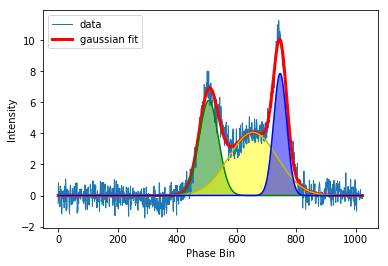

In [22]:
plot_fill(x,y,params)

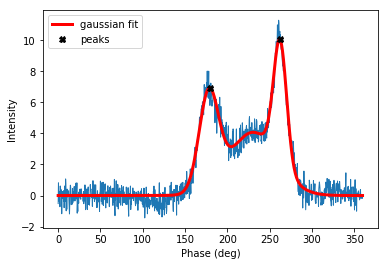

In [23]:
plot_peaks(x*(360/1024),y,profile_comp)

#### EPTA/Parkes data set

In [24]:
phase=highfrequencyprofile['phase']
intensity=highfrequencyprofile['intensity']
x = phase
y=[]

#Used to bring the data down, to be centred at 0
m=statistics.mean(intensity[600:])
for i in intensity:
    y.append(i-m)

#Expected is taken from Peaks and Gaussian fittings of this frequency band
expected=(25,270,30,20,370,80,20,470,20)
params, cov, sigma = fitting_parameters(x,y,expected)
fit = multi_gauss(x,*params)
profile_comp = gauss_peaks(fit, 1, 0, cov, params,1396,1397)

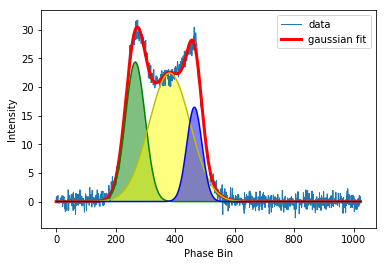

In [25]:
plot_fill(x,y,params)

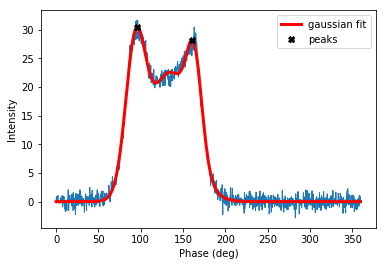

In [26]:
plot_peaks(x*(360/1024),y,profile_comp)

#### MWA Data Set

In [27]:
freqband = 5
f = averagemprofiles['frequency'] == freqband
phase=averagemprofiles['phase'][f]
intensity=averagemprofiles['intensity'][f]
x = phase
y = intensity

#Expected is taken from Peaks and Gaussian fittings of frequency band 6
expected=(0.03,65,9,0.02,90,30,0.07,135,5,0.04,150,9)
params,cov,sigma = fitting_parameters(x,y,expected)
fit = multi_gauss(x,*params)
profile_comp = gauss_peaks(fit, nom_freq_bands, freqband, cov, params,170,200)

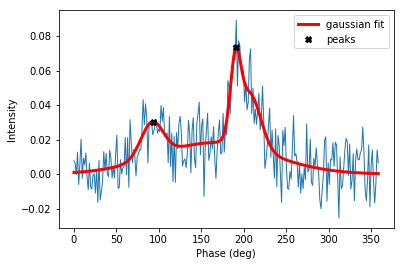

In [28]:
plot_peaks(x*(360/256),y,profile_comp)

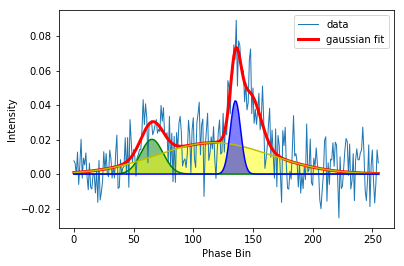

In [29]:
plot_fill(x,y,params)

In [30]:
params

array([2.01605898e-02, 6.54082012e+01, 9.29372972e+00, 1.82024557e-02,
       1.17087881e+02, 4.77137218e+01, 4.25723595e-02, 1.35356797e+02,
       4.33458241e+00, 3.16874948e-02, 1.47409584e+02, 9.11485655e+00])

#### MWA Profile

In [31]:
phase=mwaprofile['phase']
intensity=mwaprofile['intensity']
x = phase
y = intensity

#Expected is taken from Peaks and Gaussian fittings of this frequency band
expected=(0.04,250,40,0.02,400,100,0.06,550,45,0.02,600,100)
params,cov,sigma = fitting_parameters(x,y,expected)
fit = multi_gauss(x,*params)
profile_comp = gauss_peaks(fit, 1, 0, cov, params,185,186)

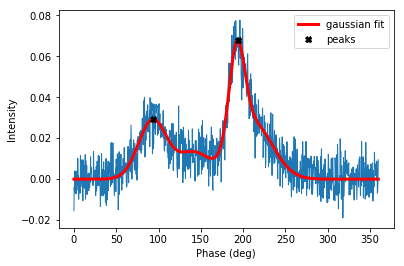

In [32]:
plot_peaks(x*(360/1024),y,profile_comp)

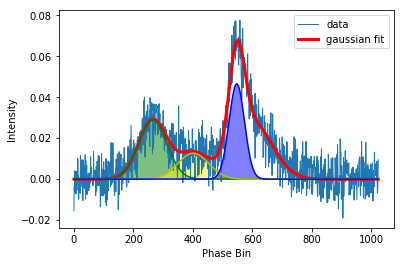

In [33]:
plot_fill(x,y,params)

# ALL FREQUENCY BANDS

# Gaussian Plotting and Finding Peaks of Overall Fit


The following is a looped version of the previous section to find the correct peaks for each pulse profile

#### GMRT Data

In [34]:
fit_components = []
#Taken from Peaks and Gaussian fittings of frequency band 73, in the middle
expected=(7,505,30,4,655,80,9,745,20)

#Loop thought all of the frequency bands
for i in range(0,no_freq_bands):
    freqband = i
    f = averageprofiles['frequency'] == freqband
    x=averageprofiles['phase'][f]
    y=averageprofiles['intensity'][f]

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        params,cov,sigma = fitting_parameters(x,y,expected)
        fit = multi_gauss(x,*params)
        profile_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params, 300, 500)
  
        fit_components.append(profile_comp)

#### EPTA Data

In [35]:
#Do the above but for only one frequency
expected=(25,270,30,20,370,80,20,470,20)

phase=highfrequencyprofile['phase']
intensity=highfrequencyprofile['intensity']
x = phase
y=[]

#Used to bring the data down, to be centred at 0
m=statistics.mean(intensity[600:])
for i in intensity:
    y.append(i-m)

#Fit the gaussians and find peaks and errors
#Resulting frequencies are in MHz and phase in degrees
if len(x)!=0 and len(y)!=0:
    params,cov,sigma = fitting_parameters(x,y,expected)
    fit = multi_gauss(x,*params)
    profile_compsh = gauss_peaks(fit, 1, 0, cov, params,1396,1397)

#### MWA Data

In [36]:
fitm_components = []
#Taken from Peaks and Gaussian fittings of frequency band 6, in the middle
expected=(0.03,65,9,0.02,90,30,0.07,135,5,0.04,150,9)
#Loop thought all of the frequency bands
for i in reversed(range(0,nom_freq_bands)):
    freqband = i
    
    f = averagemprofiles['frequency'] == freqband
    x=averagemprofiles['phase'][f]
    y=averagemprofiles['intensity'][f]
    
    #Reversing order since MWA pdv file is ordered backwards
    freqband = nom_freq_bands-1-i

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        params,cov,sigma = fitting_parameters(x,y,expected)
        fit = multi_gauss(x,*params)
        profile_comp = gauss_peaks(fit, nom_freq_bands, freqband, cov, params,169.6,200.32)
  
        fitm_components.append(profile_comp)

#### MWA Profile

In [37]:
#Do the above but for only one frequency
expected=(0.04,250,40,0.02,400,100,0.06,550,45,0.02,600,100)

phase=mwaprofile['phase']
intensity=mwaprofile['intensity']
x = phase
y = intensity

#Fit the gaussians and find peaks and errors
#Resulting frequencies are in MHz and phase in degrees
if len(x)!=0 and len(y)!=0:
    params,cov, sigma = fitting_parameters(x,y,expected)
    fit = multi_gauss(x,*params)
    profile_compm = gauss_peaks(fit, 1, 0, cov, params,185,186)

# Change of Peak Position over Frequency

Starting to graph out all the movement of component phase across frequency

## GMRT

### Component 1

<Container object of 3 artists>

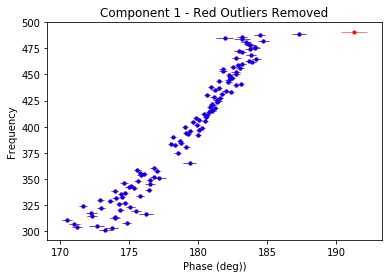

In [38]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp1, frequency_comp1, comp1_err=graphing_comp(fit_components,1)
#Plot points
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, color='red', label='data')
py.title('Component 1 - Red Outliers Removed')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
#Remove outliers which are greater than 'threshold' number of std away from the mean
frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err,3)
#Plot outlier removed points
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, color='blue',label='data')

In [39]:
#Fit the thorsett model to the component position
y_range=list(range(290, 510))
expect=(500,0.4,16)
comp1_params,comp1_cov=curve_fit(thorsett,frequency_comp1,phase_comp1, expect, maxfev=100000, sigma=comp1_err, bounds=([0,-np.inf,0],[np.inf,np.inf,np.inf]))
comp1_fit_error=np.sqrt(np.diag(comp1_cov))
comp1_fit = thorsett(y_range, *comp1_params)
#Fit a powerlaw to component position
comp1_paramspl,comp1_covpl=curve_fit(powerlaw,frequency_comp1,phase_comp1, maxfev=10000, sigma=comp1_err)
comp1_fit_errorpl=np.sqrt(np.diag(comp1_covpl))
comp1_fitpl = powerlaw(y_range, *comp1_paramspl)
comp1_fitpl2 = powerlaw(frequency_comp1, *comp1_paramspl)

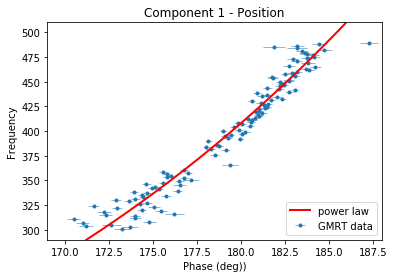

In [40]:
#Graph points with the fit ontop
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, label='GMRT data', zorder=0)
py.plot(comp1_fitpl,y_range, color='red',lw=2, label='power law', zorder=1)
py.title('Component 1 - Position')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
py.legend(loc='lower right')
py.axis([169,188,290,510])
py.savefig('figures/Comp1_pos.png')

In [41]:
print(f'The thorsett equation of fit for this pulse is: \t Phase = {comp1_params[0]:.3f} \u03BD^{comp1_params[1]:.3f} + {comp1_params[2]:.3f}')
print(f'The errors are {comp1_fit_error[0]}, {comp1_fit_error[1]}, {comp1_fit_error[2]} \n')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp1_paramspl[0]:.3f} \u03BD^{comp1_paramspl[1]:.3f}')
print(f'The errors are {comp1_fit_errorpl[0]}, {comp1_fit_errorpl[1]}')

The thorsett equation of fit for this pulse is: 	 Phase = 74.627 ν^0.146 + 0.000
The errors are 338.6908725358195, 0.35496622328909877, 432.7800796827825 

The power law equation of fit for this pulse is: 	 Phase = 74.627 ν^0.146
The errors are 1.3503087207260331, 0.003024865386019411


In [42]:
print('The chi squared reduced value is', chsq_err(phase_comp1, comp1_fitpl2, comp1_err)/(len(phase_comp1)-2))

The chi squared reduced value is 7.86382296590601


### Component 2

<Container object of 3 artists>

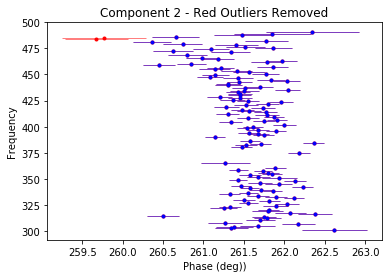

In [43]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp2, frequency_comp2, comp2_err=graphing_comp(fit_components,2)
#Plot points
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, color='red', label='data')
py.title('Component 2 - Red Outliers Removed')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
#Remove outliers which are greater than 'threshold' number of std away from the mean
frequency_comp2, phase_comp2, comp2_err = detect_outlier(frequency_comp2, phase_comp2, comp2_err,3)
#Plot outlier removed points
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, color='blue',label='data')

In [44]:
#Fit the thorsett model to the component position
expect=(700,0.4,16)
comp2_params,comp2_cov=curve_fit(thorsett,frequency_comp2,phase_comp2, expect, maxfev=10000, sigma=comp2_err, bounds=([0,-np.inf,0],[np.inf,np.inf,np.inf]))
comp2_fit_error=np.sqrt(np.diag(comp2_cov))
comp2_fit = thorsett(y_range, *comp2_params)
#Fit a powerlaw to the component position
comp2_paramspl,comp2_covpl=curve_fit(powerlaw,frequency_comp2,phase_comp2, maxfev=10000, sigma=comp2_err)
comp2_fit_errorpl=np.sqrt(np.diag(comp2_covpl))
comp2_fitpl = powerlaw(y_range, *comp2_paramspl)
comp2_fitpl2 = powerlaw(frequency_comp2, *comp2_paramspl)

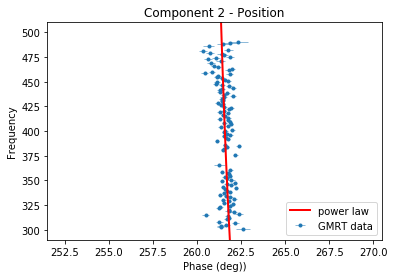

In [45]:
#Graph points with the fit ontop
py.errorbar( phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, label='GMRT data', zorder=0)
py.plot(comp2_fitpl,y_range, color='red',lw=2, label='power law', zorder=1)
py.title('Component 2 - Position')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
py.legend(loc='lower right')
py.axis([251.5,270.5,290,510])
py.savefig('figures/Comp2_pos.png')

In [46]:
print(f'The thorsett equation of fit for this pulse is: \t Phase = {comp2_params[0]:.3f} \u03BD^{comp2_params[1]:.3f} + {comp2_params[2]:.3f}')
print(f'The errors are {comp2_fit_error[0]}, {comp2_fit_error[1]}, {comp2_fit_error[2]} \n')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp2_paramspl[0]:.3f} \u03BD^{comp2_paramspl[1]:.3f}')
print(f'The errors are {comp2_fit_errorpl[0]}, {comp2_fit_errorpl[1]}')

The thorsett equation of fit for this pulse is: 	 Phase = 266.932 ν^-0.003 + 0.000
The errors are 359436.8146506598, 4.644484727433432, 359510.35996874684 

The power law equation of fit for this pulse is: 	 Phase = 266.932 ν^-0.003
The errors are 1.3962698674901, 0.0008790393757696368


In [47]:
print('The chi squared reduced value is',chsq_err(phase_comp2, comp2_fitpl2, comp2_err)/(len(phase_comp2)-2))

The chi squared reduced value is 4.187192404990951


## MWA

## Component 1

Text(0,0.5,'Frequency')

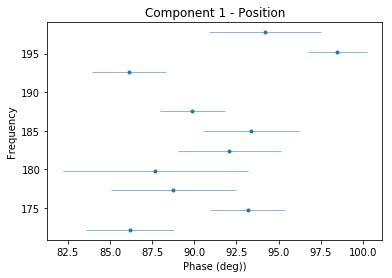

In [48]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phasem_comp1,frequencym_comp1,comp1m_err=graphing_comp(fitm_components,1)

#Plot points
py.errorbar(phasem_comp1,frequencym_comp1, xerr=comp1m_err, fmt='.', lw=0.5, label='data')
py.title('Component 1 - Position')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')

In [49]:
#Fit the thorsett model to the component position
expect=(500,0.4,16)
comp1m_params,comp1m_cov=curve_fit(thorsett,frequencym_comp1,phasem_comp1, maxfev=100000, sigma=comp1m_err)
comp1m_fit_error=np.sqrt(np.diag(comp1m_cov))
comp1m_fit = thorsett(frequencym_comp1, *comp1m_params)

### Component 2

Text(0,0.5,'Frequency')

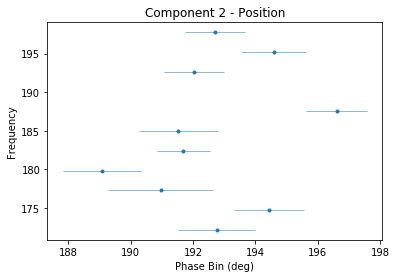

In [50]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phasem_comp2,frequencym_comp2,comp2m_err=graphing_comp(fitm_components,2)

#Plot points
py.errorbar(phasem_comp2,frequencym_comp2, xerr=comp2m_err, fmt='.', lw=0.5, label='data')
py.title('Component 2 - Position')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

In [51]:
#Fit the thorsett model to the component position
expect=(700,0.4,16)
comp2m_params,comp2m_cov=curve_fit(thorsett,frequencym_comp2,phasem_comp2, maxfev=10000, sigma=comp2m_err, bounds=([0,-1,0],[1000,0.5,np.inf]))
comp2m_fit_error=np.sqrt(np.diag(comp2m_cov))
comp2m_fit = thorsett(frequencym_comp2, *comp2m_params)

# Fitting Power Laws to Separation 

## Just GMRT

In [52]:
#Gain component separation values
component_sep, sep_error = separation_singleprofile(fit_components)

comp_sep=[]
frequency_forsep=[]

#Put them into arrays for graphing
for i in range(0,len(component_sep)):
    comp_sep.append(component_sep[i][1])
    frequency_forsep.append(component_sep[i][0])

Text(0.5,1,'Component Separation - Red Outliers Removed')

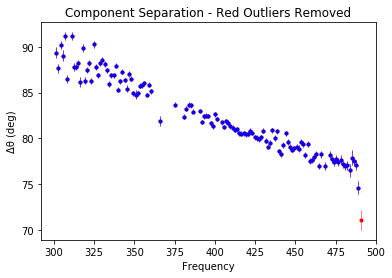

In [53]:
#Plot points
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, color='red', fmt='.', lw=0.5, label='data')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

#Remove outliers
frequency_forsep, comp_sep, sep_error = detect_outlier(frequency_forsep, comp_sep, sep_error, 2.5)

#Plot points with outliers removed
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, color='blue', fmt='.', lw=0.5, label='data')
py.title('Component Separation - Red Outliers Removed')

In [54]:
#Create a thorsett fit
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))
separation_fit=thorsett(frequency_forsep,*sep_params)

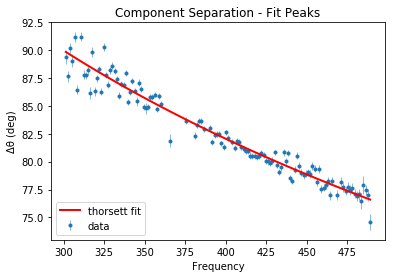

In [55]:
#Plot the thorsett fit
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data',zorder=1)
py.plot(frequency_forsep,separation_fit, color='red',lw=2,label='thorsett fit',zorder=2)
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')

In [56]:
#chi, p = sp.stats.chisquare(comp_sep, separation_fit)
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
#print('The chi squared value for the fit is: ', chi)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')
print('The chi squared reduced value is',chsq_err(comp_sep, separation_fit, sep_error)/(len(comp_sep)-2))

The equation of fit for this pulsar is: 	 Δθ = 658.219 ν^-0.059 + -380.062 

The errors are 2539.474, 0.351, 2755.185 
Units for Δθ is degrees and ν is MHz
The chi squared reduced value is 6.027151463488418


### GMRT, PARKES and MWA Profile

In [57]:
#Make a copy of the GMRT data arrays
y_sep=comp_sep.copy()
x_sep=frequency_forsep.copy()
err_sep=sep_error.copy()

#Find separation value of Parkes point
h_fit_components=[]
h_fit_components.insert(0,profile_compsh)
h_component_sep,h_sep_error = separation_singleprofile(h_fit_components)

#Insert Parkes data into overall arrays
y_sep.insert(0,h_component_sep[0][1])
x_sep.insert(0,h_component_sep[0][0])
err_sep.insert(0, h_sep_error[0])

In [58]:
#Find separation value of MWA point
m_fit_components=[]
m_fit_components.insert(0,profile_compm)
m_component_sep,m_sep_error = separation_singleprofile(m_fit_components)

#Insert Parkes data into overall arrays
y_sep.append(m_component_sep[0][1])
x_sep.append(m_component_sep[0][0])
err_sep.append(m_sep_error[0])

In [59]:
#Find a thorsett fit
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,x_sep,y_sep, expect, sigma=err_sep, maxfev=10000,  bounds=([0,-np.inf,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))
y_fit=thorsett(x_sep,*sep_params)

In [60]:
#Create an ongoing fit which spans the full range of values
sepa_fit=[]
x_sepa_fit=list(range(100,1500))
sepa_fit_errors=[]
for i in x_sepa_fit:
    sepa_fit.append(sep_params[0]*(i**(sep_params[1]))+sep_params[2])
    sepa_fit_errors.append(np.sqrt(((i**(sep_params[1])*(sep_fit_error[0]))**2)+(((np.log(i)*sep_params[0]*i**(sep_params[1]))*(sep_fit_error[1]))**2)+((1*(sep_fit_error[2]))**2)))

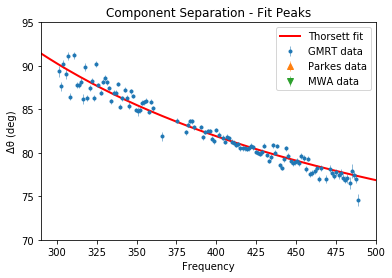

In [61]:
#Plot all points and overall fit
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='GMRT data')
py.errorbar(h_component_sep[0][0], h_component_sep[0][1], yerr=h_sep_error[0], fmt='^', lw=0.5, label='Parkes data')
py.errorbar(m_component_sep[0][0], m_component_sep[0][1], yerr=m_sep_error[0], fmt='v', lw=0.5, label='MWA data')
py.plot(x_sepa_fit,sepa_fit, color='red',lw=2,label='Thorsett fit')
#py.axis((290,500,70,95))
#py.axis((160,500,70,110))
py.axis((120,1500,62,110))
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='upper right')
py.savefig('figures/Sep_nofillA.png')
py.axis((290,500,70,95))
py.savefig('figures/Sep_nofillB.png')

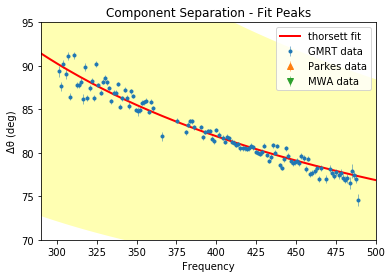

In [62]:
#Plot with errors taken from curve fit
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='GMRT data')
py.errorbar(h_component_sep[0][0], h_component_sep[0][1], yerr=h_sep_error[0], fmt='^', lw=0.5, label='Parkes data')
py.errorbar(m_component_sep[0][0], m_component_sep[0][1], yerr=m_sep_error[0], fmt='v', lw=0.5, label='MWA data')
py.plot(x_sepa_fit,sepa_fit, color='red',lw=2,label='thorsett fit')
py.fill_between(x_sepa_fit, np.array(sepa_fit) - np.array(sepa_fit_errors), np.array(sepa_fit) + np.array(sepa_fit_errors), facecolor='yellow', alpha=0.3)
#py.axis((160,500,70,110))
py.axis((125,1500,62,110))
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='upper right')
py.savefig('figures/SepA.png')
py.axis((290,500,70,95))
py.savefig('figures/SepB.png')

In [63]:
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

The equation of fit for this pulsar is: 	 Δθ = 9348.738 ν^-0.985 + 56.352 

The errors are 3318.210, 0.070, 1.651 
Units for Δθ is degrees and ν is MHz


In [64]:
print('The chi squared reduced value is',chsq_err(y_sep, y_fit, err_sep)/(len(phase_comp2)-2))

The chi squared reduced value is 7.552723684233074


# Change in Intensity over Frequency for GMRT

## Fit Peaks (fit_components)

Text(0,0.5,'Intensity')

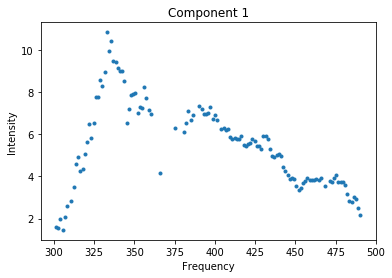

In [65]:
#Find intensity of components at each frequency and graph
intensity_comp1=[]
frequency_comp1=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp1.append(fit_components[i][1][1])
    frequency_comp1.append(fit_components[i][0])
    
py.plot(frequency_comp1,intensity_comp1, '.')
py.title('Component 1')
py.xlabel('Frequency')
py.ylabel('Intensity')

Text(0,0.5,'Intensity')

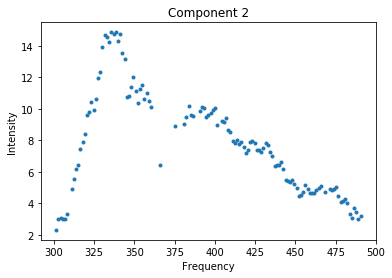

In [66]:
#Find intensity of components at each frequency and graph
intensity_comp2=[]
frequency_comp2=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp2.append(fit_components[i][2][1])
    frequency_comp2.append(fit_components[i][0])

py.plot(frequency_comp2,intensity_comp2, '.')
py.title('Component 2')
py.xlabel('Frequency')
py.ylabel('Intensity')